# Model for Life Expectancy

**Team:**<br>
Emma | Hong-Kiu | Raphael

**The objective of the model is:**

- Build model that will predict the life expectancy based on features provided in the dataset
- Explore which factors are responsible for higher life expectancy
- Give recommendations to improve life expectancy in specific countries

**Data:**<br>
Collected by World Health Organization (WHO) and United Nations (UN). The final dataset consists of 22 columns (20 predicting variables) and 2938 row containing data collected from the year 2000-2015 of 193 countries. All predicting variables were divided into the following broad categories:

- Immunization related factors
- Mortality factors
- Economical factors
- Social factors

    Link to the Dataset:<br>
    [Life-Expectancy | Kaggle.com](https://www.kaggle.com/kumarajarshi/life-expectancy-who)<br>
    [GDP | worldbank.org](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)

**Table of contents:**<a name="index"></a>
1. [Import Libraries](#libraries)
2. [Load datasets and clean column-names ](#files)
3. [Interpret and clean Data](#look)<br>
    3.1 [Statistics-Table](#describe)<br>
    3.2 [Pairplot](#pairplot)<br>
4. [Clean Data](#clean)<br>
    4.1 [Add GDP Dataset](#gdp)<br>
    4.2 [Clean column polio](#polio)<br>
    4.3 [Clean column infant deaths](#infant)<br>
5. [Drop messy columns and rows with NaN](#drop)<br>
    5.1 [Correlation Matrix](#corr_matrix)<br>
    5.2 [Drop highly correlating columns](#drop_corr)<br>
    5.3 [Scatterplot of messy columns](#scatter)<br>
    5.4 [Drop messy columns](#drop_messy)<br>
    5.5 [Replace 0 | drop NaN](#drop_nan)<br>
    5.6 [Drop countries fewer records](#drop_countries)<br>
    5.7 [Remove outliers](#outliers)<br>
    5.8 [CSV-Output for Tableau](#csv_tableau)<br>
6. [Model: Linear regression](#model)<br>
    6.1 [Train and plot model v1](#model_train)<br>
    6.2 [Optimize Model](#model_optimize)<br>
    6.3 [Feature importance](#model_feature)<br>
    6.4 [Output: Model-Parameter/-Formula](#model_save)<br>


In [1]:
# Marker for updating csvs:
update_csv = False
update_mod_parameter = False
update_mod_formula = False

## 1. Import libraries <a name="libraries"></a>

Import necessary libraries for data-handling, plotting, modeling.

[↑ back to top ↑](#index)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

## 2. Load datasets and clean column-names <a name="files"></a>
Loading datasets into panda dataframes and clean column-names (lower case, no space)

[↑ back to top ↑](#index)

Create functions for loading and cleaning column names

In [3]:
# load csv files with line 0 as default header
def load_original_data(a,line_header=0): 
    df = pd.read_csv(a,header=line_header)
    return df

# function to make column lower case
def lower_case_column_names(df):
    df.columns=[i.lower() for i in df.columns]
    return df

#
def no_column_space(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df

Apply function on the our initial dataset - **Life Expectancy**.

In [4]:
df = load_original_data('data/Life Expectancy Data.csv') 

df = lower_case_column_names(df)

df = no_column_space(df)

df = df.drop_duplicates()

Sort columns of life expectancy dataframe

In [5]:
df.columns = (['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population',
       'thinness_1_19_years', 'thinness_5-9_years',
       'income_composition_of_resources','schooling'])
df = df[['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population',
       'thinness_1_19_years', 'thinness_5-9_years','schooling',
       'income_composition_of_resources']]

## 3. Interpret and clean data <a name="look"></a>
Have a look at the data provided in the individual columns. 
Decide to: Clean columns if possible, drop (whole column or individual) or get alternative data.

[↑ back to top ↑](#index)

### 3.1 Have a look at the data provided in the individual columns. <a name="describe"></a>
[↑ back to top ↑](#index)

In [6]:
df_describe = pd.DataFrame({"% NaN" : round(df.isna().sum()/len(df),4)*100, "% 0.0" : round(df[df == 0].count(axis=0)/len(df.index)* 100,2)}).transpose()
df_describe.append(df.describe(include='all')).transpose()

,% NaN,% 0.0,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,0.0,0.0,2938,193,Afghanistan,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,0.0,0.0,2938.0,NaN,NaN,NaN,2007.51872,4.613841,2000.0,2004.0,2008.0,2012.0,2015.0
status,0.0,0.0,2938,2,Developing,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
life_expectancy,0.34,0.0,2928.0,NaN,NaN,NaN,69.224932,9.523867,36.3,63.1,72.1,75.7,89.0
adult_mortality,0.34,0.0,2928.0,NaN,NaN,NaN,164.796448,124.292079,1.0,74.0,144.0,228.0,723.0
infant_deaths,0.0,28.86,2938.0,NaN,NaN,NaN,30.303948,117.926501,0.0,0.0,3.0,22.0,1800.0
alcohol,6.6,0.0,2744.0,NaN,NaN,NaN,4.602861,4.052413,0.01,0.8775,3.755,7.7025,17.87
percentage_expenditure,0.0,20.8,2938.0,NaN,NaN,NaN,738.251295,1987.914858,0.0,4.685343,64.912906,441.534144,19479.91161
hepatitis_b,18.82,0.0,2385.0,NaN,NaN,NaN,80.940461,25.070016,1.0,77.0,92.0,97.0,99.0
measles,0.0,33.46,2938.0,NaN,NaN,NaN,2419.59224,11467.272489,0.0,0.0,17.0,360.25,212183.0


### 3.2 Have a look at the pairplots: <a name="pairplot"></a>
- Check for high correlation
- Check for inconsistencies<br>
[↑ back to top ↑](#index)

In [7]:
#sns.pairplot(df.drop(['year','country'],axis=1))

## 4. Clean Dataset<a name="Clean"></a>
Add alternative Data (GDP.)<br>
Drop columns that are to messy to clean.<br>
Drop rows with NaN/Zeroes

[↑ back to top ↑](#index)

In [8]:
# Function for fast scatterplot and histogram (2 columns as input)
def plot_scatter_hist(df_x,df_y):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    sns.regplot(ax=ax[0],x=df_x,y=df_y, data=df, scatter_kws={"color": '#3e6b97'}, line_kws={"color": "black"})
    ax[0].set_xlabel(df_x)
    ax[0].set_ylabel(df_y)
    ax[0].set_title(df_x +' vs '+ df_y)

    # Get a histogram of polio
    ax[1].hist(df_y,data=df)
    ax[1].set_xlabel(df_y)
    ax[1].set_title(df_y + " histogram")

### 4.1 Add additional Dataset with GDP-Values for different countries<a name="gdp"></a>
It turned out that the column gdp of the dataset life expectancy was messy and difficult to clean (random messyness -> has to be manually cleaned).<br>
So we decided to import gdp data via another dataset distributed by worldbank.org.<br>
Apply import- and column-clean-functions on additonal gdp-dataset.<br>
[↑ back to top ↑](#index)

In [9]:
# Import second database for cleaning gdp
df_gdp = load_original_data('Data/GDP.csv',2)
df_gdp = lower_case_column_names(df_gdp)
df_gdp = no_column_space(df_gdp)
df_gdp.index =df_gdp['country_name'] # set country as index
df_gdp = df_gdp.drop(columns=['country_name','country_code','indicator_name','indicator_code']) # drop some unesessary columns

In [10]:
# build function to clean gdp column with new values of 2nd dataframe
# function ignores values of new datafram if value is NaN
def replace_gdp(df_insert_values,df_get_values):
    list_to_replace = []
    country_not_matched = []
    # Dictionary with some countries manually matched (compared first 4 characters)
    dic_substitutes = {'Bahamas':'Bahamas, The',
                        'Bolivia (Plurinational State of)':'Bolivia',
                        'Congo':'Congo, Rep.',
                        'Czechia':'Czech Republic',
                        'Democratic Republic of the Congo':'Congo, Dem. Rep.',
                        'Egypt':'Egypt, Arab Rep.',
                        'Gambia':'Gambia, The',
                        'Iran (Islamic Republic of)':'Iran, Islamic Rep.',
                        'Kyrgyzstan':'Kyrgyz Republic',
                        "Lao People's Democratic Republic":'Lao PDR',
                        'Micronesia (Federated States of)':  'Micronesia, Fed. Sts.',
                        'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                        'United States of America':'United States',
                        'Venezuela (Bolivarian Republic of)':'Venezuela, RB',
                        'Viet Nam':'Vietnam',
                        'Yemen':'Yemen, Rep.'}
    for row in df_insert_values.index: #loops through rows of df to be updated
        country = df_insert_values.country[row] #saves country of that row - gdp df has country_name as index
        year = str(df_insert_values.year[row]) #saves year of that row as string - gdp df has years (String) as columns
        if country in df_get_values.index and not pd.isnull(df_get_values.loc[country,year]): # check if country can be matched
            df.loc[row,'gdp'] = df_get_values.loc[country,year] #replace gdp-value
        else: #if country is not matchable
            if country not in list_to_replace: #replace manually
                list_to_replace.append(country) #add country to looping list
                if country in dic_substitutes.keys() and not pd.isnull(df_get_values.loc[dic_substitutes[country],year]): #get corresponding country_name
                    df.loc[row,'gdp'] = df_get_values.loc[dic_substitutes[country],year]
                else:
                    country_not_matched.append(country) #add to list of unmatchable countries
    return country_not_matched

In [11]:
## Apply function on df
replace_gdp(df,df_gdp) #has not matchable countries or countries with NaN values as output 

['Afghanistan',
 "Côte d'Ivoire",
 'Cook Islands',
 "Democratic People's Republic of Korea",
 'Eritrea',
 'Niue',
 'Republic of Korea',
 'Republic of Moldova',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Slovakia',
 'Somalia',
 'South Sudan',
 'Swaziland',
 'Syrian Arab Republic',
 'The former Yugoslav republic of Macedonia',
 'United Republic of Tanzania',
 'Venezuela (Bolivarian Republic of)']

### 4.2 Clean column polio<a name="polio"></a>
Scatterplot and Histogram show high discrepancy in scattering.
High amount of values with a hard border at polio~17 
    -> Assumption: values are wrong by *10 -> clean by multiplying every value below 17 by 10

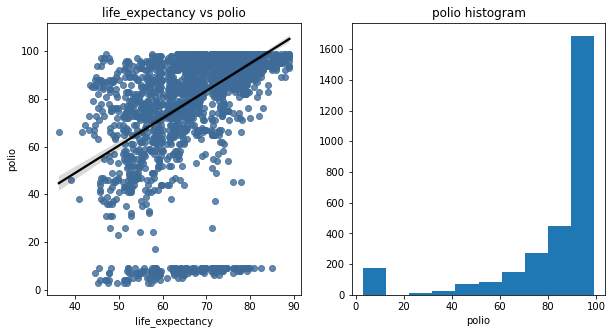

In [12]:
# Get Scatterplot/Histrogram to highlight irregularities in scattering
plot_scatter_hist('life_expectancy','polio')

In [13]:
# Multiplying every value below 17 by 10
df.loc[(df.polio <17),'polio'] *= 10

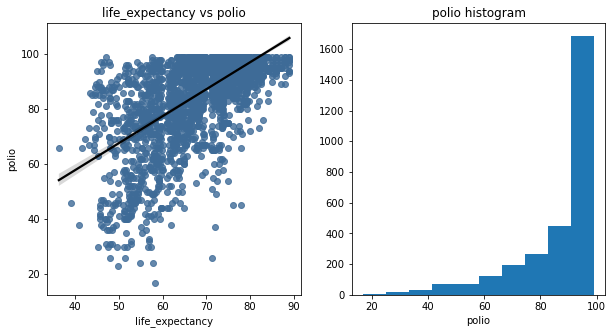

In [14]:
# Have a look at the scatterplot again.
plot_scatter_hist('life_expectancy','polio')

Scatter looks a lot more 'natural'

### 4.3 Clean column infant deaths<a name="infant"></a>
- infant deaths: in some countries a value of 0 is viable (developed / high gdp). Other countries a 0 value is not realistic (developing / low gdp).
    -> drop rows with 0 values for lower gdp 25-percentile
(rows will not be directly dropped. Incorrect 0-values will be replaced with NaN and will be dropped later with other NaN values)

In [15]:
pd.Series({"% NaN" : round(df.infant_deaths.isna().sum()/len(df),4)*100 , "% 0.0" : round((df['infant_deaths'] == 0).sum()/len(df)* 100 ,2)},name='infant_deaths').to_frame()

,infant_deaths
% NaN,0.00
% 0.0,28.86


In [16]:
# condition 1: gdp<.25-percentile
# condition 2: infant_deaths == 0
df.loc[(df.infant_deaths == 0) & (df.gdp < df.gdp.quantile(0.25)),'infant_deaths'] = np.NaN

In [17]:
pd.Series({"% NaN" : round(df.infant_deaths.isna().sum()/len(df),4)*100 , "% 0.0" : round((df['infant_deaths'] == 0).sum()/len(df)* 100 ,2)},name='infant_deaths').to_frame()

,infant_deaths
% NaN,0.68
% 0.0,28.18


## 5. Drop columns and rows<a name="drop"></a>
Drop columns/variables that are to messy to clean or are not adding to the quality of the model.<br>
Drop columns/variables that are highly correlated (<80%) <br>
Drop rows with NaN/Zeroes

[↑ back to top ↑](#index)

### 5.1 Correlation Matrix<a name="corr_matrix"></a>
Have a look at the correlation matrix to drop highly correlating variables

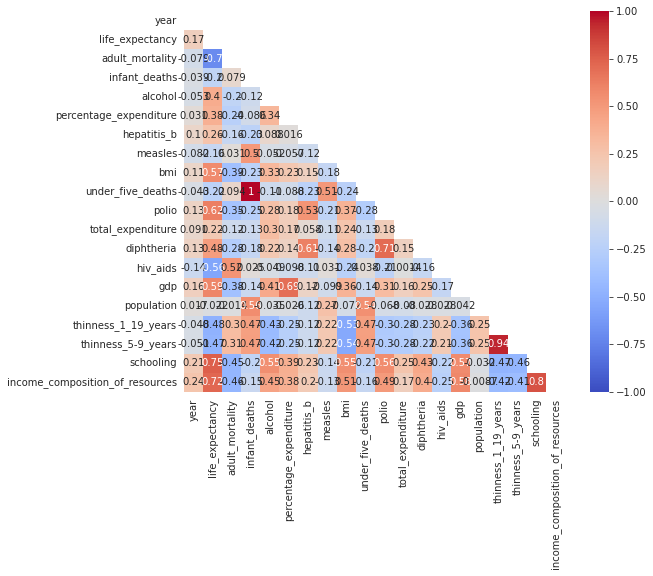

In [18]:
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr_matrix, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### 5.2 Dropping highly correlating columns<a name="drop_corr"></a>

Before dropping columns/rows: save original dataset for later use (tableau).<br>
Rows and columns will be joined after cleaning for model

In [19]:
df_original = df.copy()

Drop highly correlating variables >80%

In [20]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)] 

# Drop features 
df.drop(to_drop, axis=1, inplace=True)
print('Columns dropped: ',to_drop)

Columns dropped:  ['under_five_deaths', 'thinness_5-9_years', 'income_composition_of_resources']


### 5.3 Scatterplot of messy columns<a name="scatter"></a>
Decide on columns to drop manually, because they are too messy to clean:

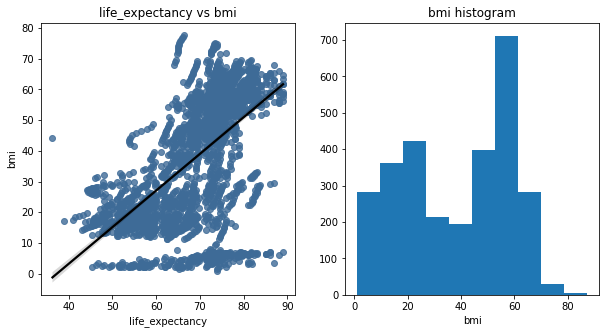

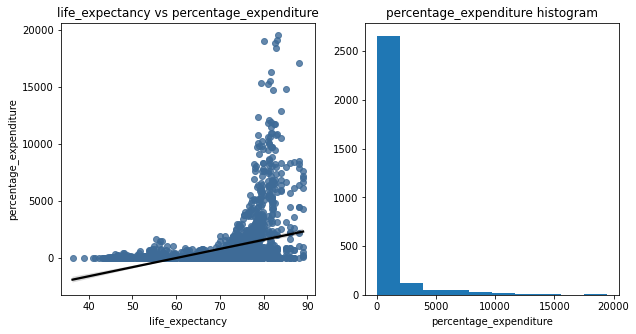

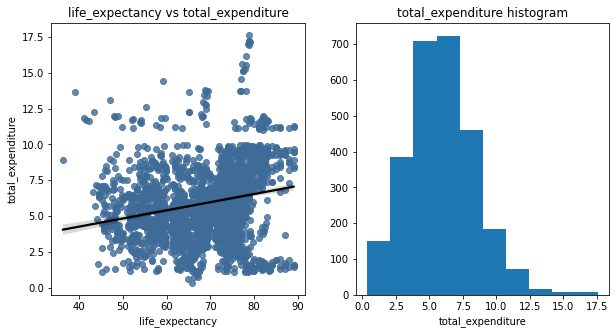

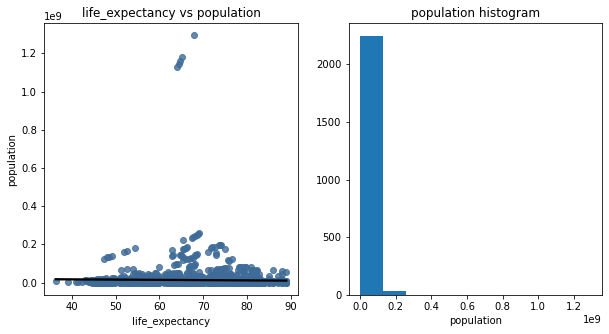

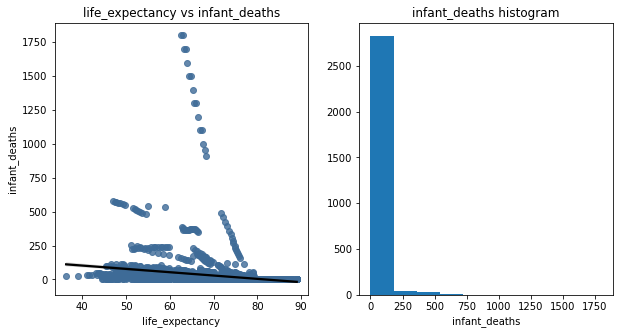

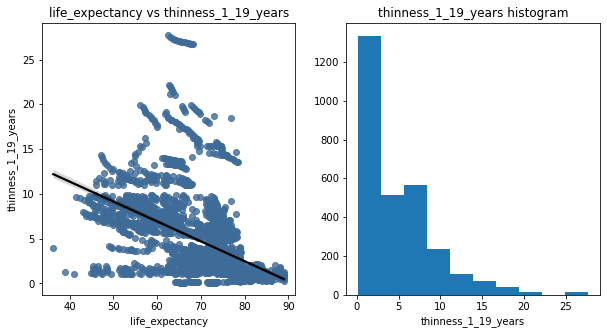

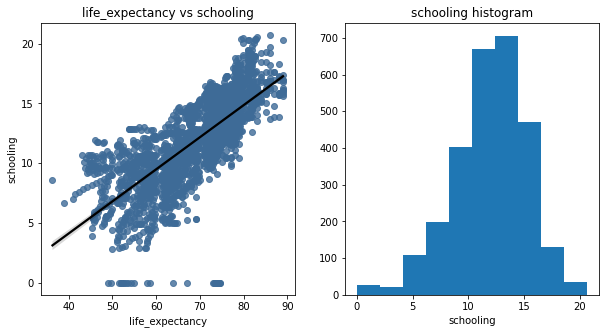

In [21]:
# Plot scatter for insight
for i in ['bmi','percentage_expenditure','total_expenditure','population','infant_deaths','thinness_1_19_years','schooling']:
    plot_scatter_hist('life_expectancy',i)

### 5.4 Columns to drop:<a name="drop_messy"></a>
- BMI: percentile 25% = 20, 50% = 42, 75% = 56 and max=87 is way too much and not cleanable (no logic for bias -> not automatically correctable)
- percentage_expenditure: 25% = 4.68, 50% = 64.91, 75% = 441.53 and max=19479.91 is not possible -> as percentage 100% would mean that all expenses of a country are for health (no logic for bias -> not automatically correctable)
- adult_mortality: is a calculated value with life expectancy as variable -> so it has to be dropped
- Population: Was added after first model. Would haven been dropped because of high p-value. Because of high amount of NaN-values will be dropped manually here to keep record-count high (see 5.3.).

In [22]:
columns_to_drop = ['bmi','percentage_expenditure', 'adult_mortality', 'year','population']

In [23]:
df.drop(columns_to_drop, axis=1, inplace = True)

### 5.5 Replace 0 | drop NaN<a name="drop_nan"></a>
Replace unvaiable zero-values with NaN and drop all NaN columns

In [24]:
pd.DataFrame({"% NaN" : round(df.isna().sum()/len(df),4)*100, "% 0.0" : round(df[df == 0].count(axis=0)/len(df.index)* 100,2)})

,% NaN,% 0.0
country,0.00,0.00
status,0.00,0.00
life_expectancy,0.34,0.00
infant_deaths,0.68,28.18
alcohol,6.60,0.00
hepatitis_b,18.82,0.00
measles,0.00,33.46
polio,0.65,0.00
total_expenditure,7.69,0.00
diphtheria,0.65,0.00


Replace 0-values of column schooling with NaN.
Drop all columns with NaN values.

In [25]:
df.schooling = df.schooling.replace(0, np.NaN)
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

### 5.6 Drop countries fewer recordss<a name="drop_countries"></a>
Countries with amount of records less than 10 will be dropped for better visualization (development over time).<br>
Countries with low amount of records are more likely to have wrong data.

In [26]:
## Records before dropping
print('Dataset contains',len(df),'records')

Dataset contains 1834 records


In [27]:
## Function to drop countries with low record-amount
def clean_missedcountry(a):
    missed_country = a[a.groupby('country')['country'].transform('size') < 10]
    missed_list = missed_country.index.tolist()
    a.drop(missed_list, inplace = True)
    return a

In [28]:
## Records before dropping
print('Dataset contains',len(clean_missedcountry(df)),'records')

Dataset contains 1653 records


### 5.7 Remove outliers<a name="outliers"></a>

In [29]:
def remove_outliers(df):
    df_n = df._get_numeric_data()
    df_c = df.select_dtypes(include=['object'])
    Q1 = df_n.quantile(0.25)
    Q3 = df_n.quantile(0.75)
    IQR = Q3 - Q1
    df_n = df_n[~((df_n < (Q1 - 1.5 * IQR)) |(df_n > (Q3 + 1.5 * IQR))).any(axis=1)]
    df = df_n.merge(df_c,how='left',left_index=True,right_index=True)
    return df
#df = remove_outliers(df)

### 5.8 Create csv with cleaned Data for Tableau<a name="csv_tableau"></a>
Columns used by model where cleaned and not used columns (not cleaned) where joined.<br>
Saved as tableau_cleaned.csv

In [30]:
## add dropped columnd to df for tabluea-dataset
df_tableau = df.merge(df_original[columns_to_drop],how='inner',left_index=True,right_index=True)

In [31]:
if update_csv:
    df_tableau.to_csv("data/tableau_cleaned.csv")

## 6 Model: Linear regression <a name="model"></a>
Define function for data splitting, scaling, modelling and plotting

[↑ back to top ↑](#index)

In [32]:
def split_scale(df,y_column):
    ''' Input: df
        Output: X_train_scaled, X_test_scaled, y_train, y_test as tuple
        Enter via split_scale(df)[i]'''
    df = df._get_numeric_data()
    X = df.drop(y_column,axis=1)
    y = df[y_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,random_state=123)
    std_scaler=StandardScaler().fit(X_train) 
    X_train_scaled=std_scaler.transform(X_train)
    X_test_scaled=std_scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
    return X_train_scaled, X_test_scaled, y_train, y_test

def apply_model(X_train, X_test, y_train, y_test, constant=True):
    if constant == True:
        X_train = sm.add_constant(X_train) # adding a constant
        X_test = sm.add_constant(X_test) # adding a constant
    model = sm.OLS(y_train, X_train).fit()
    predictions_train = model.predict(X_train)  
    predictions_test = model.predict(X_test) 
    print_model = model.summary()
    print(print_model)
    return predictions_train, predictions_test, y_train, y_test, model

def plot_model(predictions_train, predictions_test, y_train, y_test):
    # Make an scatter plot y_pred vs y
    # What kind of plot you will get if all the all the predictions are ok?
    # A stright line

    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax[0,0].plot(predictions_test, y_test, 'o')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - predictions_test)
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[1,0].plot(predictions_train, y_train, 'o')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train -predictions_train)
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")
    return
def model_df(df,y_column,constant = True):
    df_scaled = split_scale(df,y_column)
    model = apply_model(df_scaled[0],df_scaled[1],df_scaled[2],df_scaled[3],constant)
    plot_model(model[0],model[1],model[2],model[3])
    return model[4]

### 6.1 Train and plot initial model<a name="model_train"></a>

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     380.6
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:49:51   Log-Likelihood:                -3197.2
No. Observations:                1157   AIC:                             6418.
Df Residuals:                    1145   BIC:                             6479.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  70.5375    

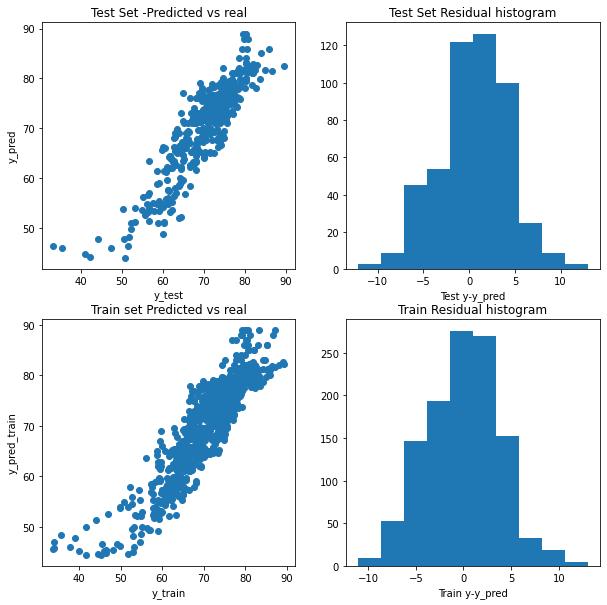

In [33]:
model_v1 = model_df(df,'life_expectancy')

### 6.2 Optimize Model by cleaning Data further<a name="model_optimize"></a>
- remove columns with high p-values

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     521.1
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:49:52   Log-Likelihood:                -3200.3
No. Observations:                1157   AIC:                             6419.
Df Residuals:                    1148   BIC:                             6464.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  70.5375    

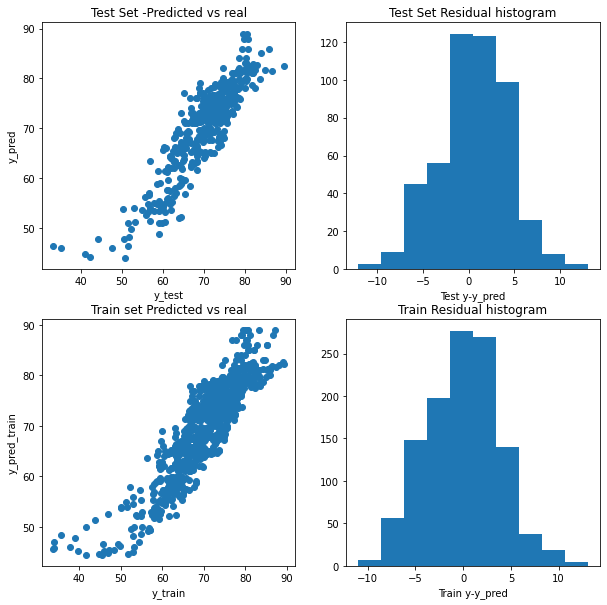

In [34]:
coef_to_remove = model_v1.pvalues[model_v1.pvalues > 0.05].index.tolist() # create list to remove coefficients with p value higher 0.05
df_v2 = df.drop(coef_to_remove,axis=1) # drop columns
# model without high p-values:
model_v2 = model_df(df_v2,'life_expectancy',constant=True)

### 6.3 Feature importance<a name="model_feature"></a>
Feature sorted by importance.

Text(0.5, 1.0, 'Feature importances obtained from coefficients, without coefficient')

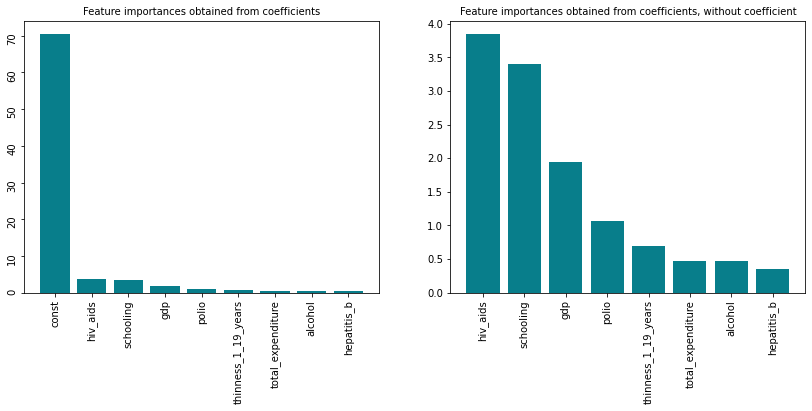

In [35]:
# Show Feature importance as barplot
mod_parameter = model_v2.params
features_importances = pd.DataFrame(data={
    'Attribute': mod_parameter.index,
    'Importance': abs(mod_parameter[:])
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances_no_const = features_importances.drop('const')

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Feature importances obtained from coefficients', size=10)
plt.xticks(rotation='vertical')
ax[1].bar(x=features_importances_no_const['Attribute'], height=features_importances_no_const['Importance'], color='#087E8B')
ax[1].set_title('Feature importances obtained from coefficients, without coefficient', size=10)

### 6.4 Save Model-Parameter to file<a name="model_save"></a>
Model Parameter saved as table to csv file: 'data/model_parameter.csv'<br>
Linear model saved as formula to txt file: 'data/model_formula.txt'

In [36]:
# Save Parameters as table in csv
mod_parameter = pd.DataFrame(model_v2.params, columns = ['coefficient'])
if update_mod_parameter:
    mod_parameter.to_csv('data/model_parameter.csv',sep=',')

In [37]:
# Model as Formula
mod_parameter = model_v2.params
formula = '0'
for i in mod_parameter.index:
    formula += ' + ' + str(round(mod_parameter[i],4)) + ' * ' + i
    #print(mod_parameter[i])
formula

'0 + 70.5375 * const + -0.4653 * alcohol + -0.3505 * hepatitis_b + 1.0602 * polio + 0.4742 * total_expenditure + -3.8487 * hiv_aids + 1.9399 * gdp + -0.6919 * thinness_1_19_years + 3.3953 * schooling'

In [38]:
# save formula as text
if update_mod_formula:
     with open('data/model_formula.txt', 'w') as f:
        f.write(formula)

[↑ back to top ↑](#index)